# Experiment 3 Analysis: Hybrid Speech Enhancement System

## Objective
Evaluate the performance of a **hybrid speech enhancement system** combining traditional Wiener Filtering with deep learning-based TinyDenoiser, and compare against individual methods.

## Systems Compared

1. **BASELINE** - Noisy speech (no enhancement)
2. **WF** - Wiener Filter alone at 25ms frame length (WF_EXP1p1d)
3. **TD** - TinyDenoiser GRU-based enhancement only (TD_EXP3p1a)
4. **WFTD** - Wiener Filter preprocessing + TinyDenoiser hybrid (WFTD_EXP3p1b)

## Analysis Goals

- **Performance Comparison**: How do the four approaches compare across objective metrics?
- **Improvement Quantification**: What percentage improvements over baseline does each method achieve?
- **Synergy Analysis**: Does the hybrid WFTD approach outperform both individual methods?
- **Noise Type Analysis**: Are there noise-specific performance patterns?
- **SNR Dependency**: How does performance vary across SNR levels?

## Metrics
- **PESQ**: Perceptual quality (1.0-4.5, higher is better)
- **STOI**: Intelligibility (0.0-1.0, higher is better)
- **SI-SDR**: Signal distortion ratio (dB, higher is better)
- **DNSMOS**: Naturalness/quality (1.0-5.0, higher is better)

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Define paths
repo_root = Path.cwd().parent.parent

In [53]:
# Set global plot parameters
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

In [54]:
BASELINE_NOIZEUS_directory = repo_root / "results" / "BASELINE" / "NOIZEUS_EARS_BASELINE"
WF_EXP1p1d_directory = repo_root / "results" / "EXP1" / "wiener" / "WF_EXP1p1d" # original WF at 25ms
TD_alone_directory = repo_root / "results" / "EXP3" / "tinydenoiser" / "TD_EXP3p1a" # TinyDenoiser GRU only
WF_TD_directory = repo_root / "results" / "EXP3" / "tinydenoiser" / "WFTD_EXP3p1b" # WF and TD
# Check directories exist else error
for directory in [BASELINE_NOIZEUS_directory, TD_alone_directory, WF_EXP1p1d_directory, WF_TD_directory]:
    if not directory.exists():
        raise FileNotFoundError(f"Directory not found: {directory}")

In [55]:
def parse_baseline_csv(snr: int) -> pd.DataFrame:
    """
    Parse BASELINE csv by SNR and NOISE_TYPE.
    
    Args:
        snr (int): SNR value (-5, 0, 5, 10, 15)
    
    Returns:
        pd.DataFrame: Grouped by noise_type with mean metrics
    """
    file_path = BASELINE_NOIZEUS_directory / f"BASELINE_NOIZEUS_EARS_[{snr}]dB.csv"
    df = pd.read_csv(file_path)
    
    # Extract noise type from enhanced_file
    df['noise_type'] = df['enhanced_file'].str.extract(r'NOIZEUS_NOISE_DATASET_(.*?)_SNR')
    
    # Group by noise_type and compute mean of numeric columns
    grouped = df.groupby('noise_type').mean(numeric_only=True)
    
    return grouped

In [56]:
def parse_wf_exp1p1d_csv(snr: int) -> pd.DataFrame:
    """
    Parse WF_EXP1p1d csv (Wiener Filter alone at 25ms) by SNR and noise_type.
    
    Args:
        snr (int): SNR value (-5, 0, 5, 10, 15)
    
    Returns:
        pd.DataFrame: Grouped by noise_type with mean metrics
    """
    file_path = WF_EXP1p1d_directory / f"WF_EXP1p1d_merged_[{snr}]dB.csv"
    df = pd.read_csv(file_path)
    
    # Extract noise type from enhanced_file
    df['noise_type'] = df['enhanced_file'].str.extract(r'NOIZEUS_NOISE_DATASET_(.*?)_SNR')
    
    # Group by noise_type and compute mean of numeric columns
    grouped = df.groupby('noise_type').mean(numeric_only=True)
    
    return grouped

In [57]:
def parse_td_alone_csv(snr: int) -> pd.DataFrame:
    """
    Parse TD_EXP3p1a csv (TinyDenoiser alone) by SNR and noise_type.
    
    Args:
        snr (int): SNR value (-5, 0, 5, 10, 15)
    
    Returns:
        pd.DataFrame: Grouped by noise_type with mean metrics
    """
    file_path = TD_alone_directory / f"TD_EXP3p1a_merged_[{snr}]dB.csv"
    df = pd.read_csv(file_path)
    
    # Extract noise type from enhanced_file
    df['noise_type'] = df['enhanced_file'].str.extract(r'NOIZEUS_NOISE_DATASET_(.*?)_SNR')
    
    # Group by noise_type and compute mean of numeric columns
    grouped = df.groupby('noise_type').mean(numeric_only=True)
    
    return grouped

In [58]:
def parse_wftd_csv(snr: int) -> pd.DataFrame:
    """
    Parse WFTD_EXP3p1b csv (Wiener Filter + TinyDenoiser) by SNR and noise_type.
    
    Args:
        snr (int): SNR value (-5, 0, 5, 10, 15)
    
    Returns:
        pd.DataFrame: Grouped by noise_type with mean metrics
    """
    file_path = WF_TD_directory / f"WFTD_EXP3p1b_merged_[{snr}]dB.csv"
    df = pd.read_csv(file_path)
    
    # Extract noise type from enhanced_file
    df['noise_type'] = df['enhanced_file'].str.extract(r'NOIZEUS_NOISE_DATASET_(.*?)_SNR')
    
    # Group by noise_type and compute mean of numeric columns
    grouped = df.groupby('noise_type').mean(numeric_only=True)
    
    return grouped

## 1. Load and Explore Data

First, let's load the data for all SNR levels and explore the structure.

In [59]:
# Define SNR levels
snr_levels = [-5, 0, 5, 10, 15]

# Load data at 5dB to explore structure
print("=" * 80)
print("BASELINE (Noisy) at 5dB SNR:")
print("=" * 80)
df_baseline_5db = parse_baseline_csv(5)
print(f"Shape: {df_baseline_5db.shape}")
print(f"\nNoise types: {sorted(df_baseline_5db.index.tolist())}")
print("\nSample metrics:")
print(df_baseline_5db[['PESQ', 'STOI', 'SI_SDR', 'DNSMOS_mos_ovr']].head())

print("\n" + "=" * 80)
print("WF (Wiener Filter alone) at 5dB SNR:")
print("=" * 80)
df_wf_5db = parse_wf_exp1p1d_csv(5)
print(f"Shape: {df_wf_5db.shape}")
print("\nSample metrics:")
print(df_wf_5db[['PESQ', 'STOI', 'SI_SDR', 'DNSMOS_mos_ovr']].head())

print("\n" + "=" * 80)
print("TD (TinyDenoiser alone) at 5dB SNR:")
print("=" * 80)
df_td_5db = parse_td_alone_csv(5)
print(f"Shape: {df_td_5db.shape}")
print("\nSample metrics:")
print(df_td_5db[['PESQ', 'STOI', 'SI_SDR', 'DNSMOS_mos_ovr']].head())

print("\n" + "=" * 80)
print("WFTD (Wiener Filter + TinyDenoiser) at 5dB SNR:")
print("=" * 80)
df_wftd_5db = parse_wftd_csv(5)
print(f"Shape: {df_wftd_5db.shape}")
print("\nSample metrics:")
print(df_wftd_5db[['PESQ', 'STOI', 'SI_SDR', 'DNSMOS_mos_ovr']].head())

BASELINE (Noisy) at 5dB SNR:
Shape: (20, 8)

Noise types: ['Car Noise_60mph', 'Car Noise_Idle Noise_40mph', 'Car Noise_Idle Noise_60mph', 'Construction_Crane_Moving', 'Construction_Drilling', 'Construction_Jackhammer1', 'Construction_Jackhammer2', 'Construction_Trucks_Unloading', 'Inside Flight', 'Inside Train_1', 'Inside Train_2', 'Inside Train_3', 'PC Fan Noise', 'SSN_IEEE', 'Street Noise', 'Street Noise_downtown', 'Train1', 'Train2', 'Water Cooler', 'cafeteria_babble']

Sample metrics:
                                PESQ      STOI    SI_SDR  DNSMOS_mos_ovr
noise_type                                                              
Car Noise_60mph             1.180366  0.737496  5.005819        2.541718
Car Noise_Idle Noise_40mph  1.097002  0.785666  5.015363        2.463229
Car Noise_Idle Noise_60mph  1.179675  0.726897  4.961920        2.408852
Construction_Crane_Moving   1.061834  0.711385  4.987167        1.714812
Construction_Drilling       1.089196  0.756539  4.963660        2.41

## 2. Performance Comparison Across All Methods

Compare four approaches:
1. **BASELINE**: Noisy speech (no enhancement)
2. **WF**: Wiener Filter alone (traditional approach)
3. **TD**: TinyDenoiser alone (deep learning approach)
4. **WFTD**: Wiener Filter + TinyDenoiser (hybrid approach)

In [60]:
# Compile all data across all SNR levels
metrics = ['PESQ', 'STOI', 'SI_SDR', 'DNSMOS_mos_ovr']

comparison_data = []

for snr in snr_levels:
    # Load data for each method
    baseline = parse_baseline_csv(snr)
    wf = parse_wf_exp1p1d_csv(snr)
    td = parse_td_alone_csv(snr)
    wftd = parse_wftd_csv(snr)
    
    # Compute overall mean for each metric
    for metric in metrics:
        comparison_data.append({
            'SNR': snr,
            'Metric': metric,
            'BASELINE': baseline[metric].mean(),
            'WF': wf[metric].mean(),
            'TD': td[metric].mean(),
            'WFTD': wftd[metric].mean()
        })

comparison_df = pd.DataFrame(comparison_data)
print("Overall Performance Comparison:")
print(comparison_df.to_string(index=False))

Overall Performance Comparison:
 SNR         Metric  BASELINE        WF        TD      WFTD
  -5           PESQ  1.065751  1.102227  1.068207  1.100816
  -5           STOI  0.586570  0.580102  0.585735  0.578654
  -5         SI_SDR -4.989893 -0.209068 -5.059958 -0.334233
  -5 DNSMOS_mos_ovr  1.970603  2.081451  1.972229  2.083038
   0           PESQ  1.093715  1.195787  1.093240  1.193687
   0           STOI  0.654918  0.656100  0.653300  0.653477
   0         SI_SDR -0.026259  4.448600 -0.183440  4.077361
   0 DNSMOS_mos_ovr  2.263054  2.159361  2.270984  2.158575
   5           PESQ  1.173282  1.386520  1.171517  1.381143
   5           STOI  0.715255  0.719145  0.713487  0.715539
   5         SI_SDR  4.995548  8.786051  4.700319  8.061499
   5 DNSMOS_mos_ovr  2.436134  2.419781  2.428181  2.428868
  10           PESQ  1.344649  1.692061  1.339880  1.680865
  10           STOI  0.773980  0.781729  0.772046  0.779207
  10         SI_SDR  9.999116 12.847617  9.393350 11.621377
  10 DNS

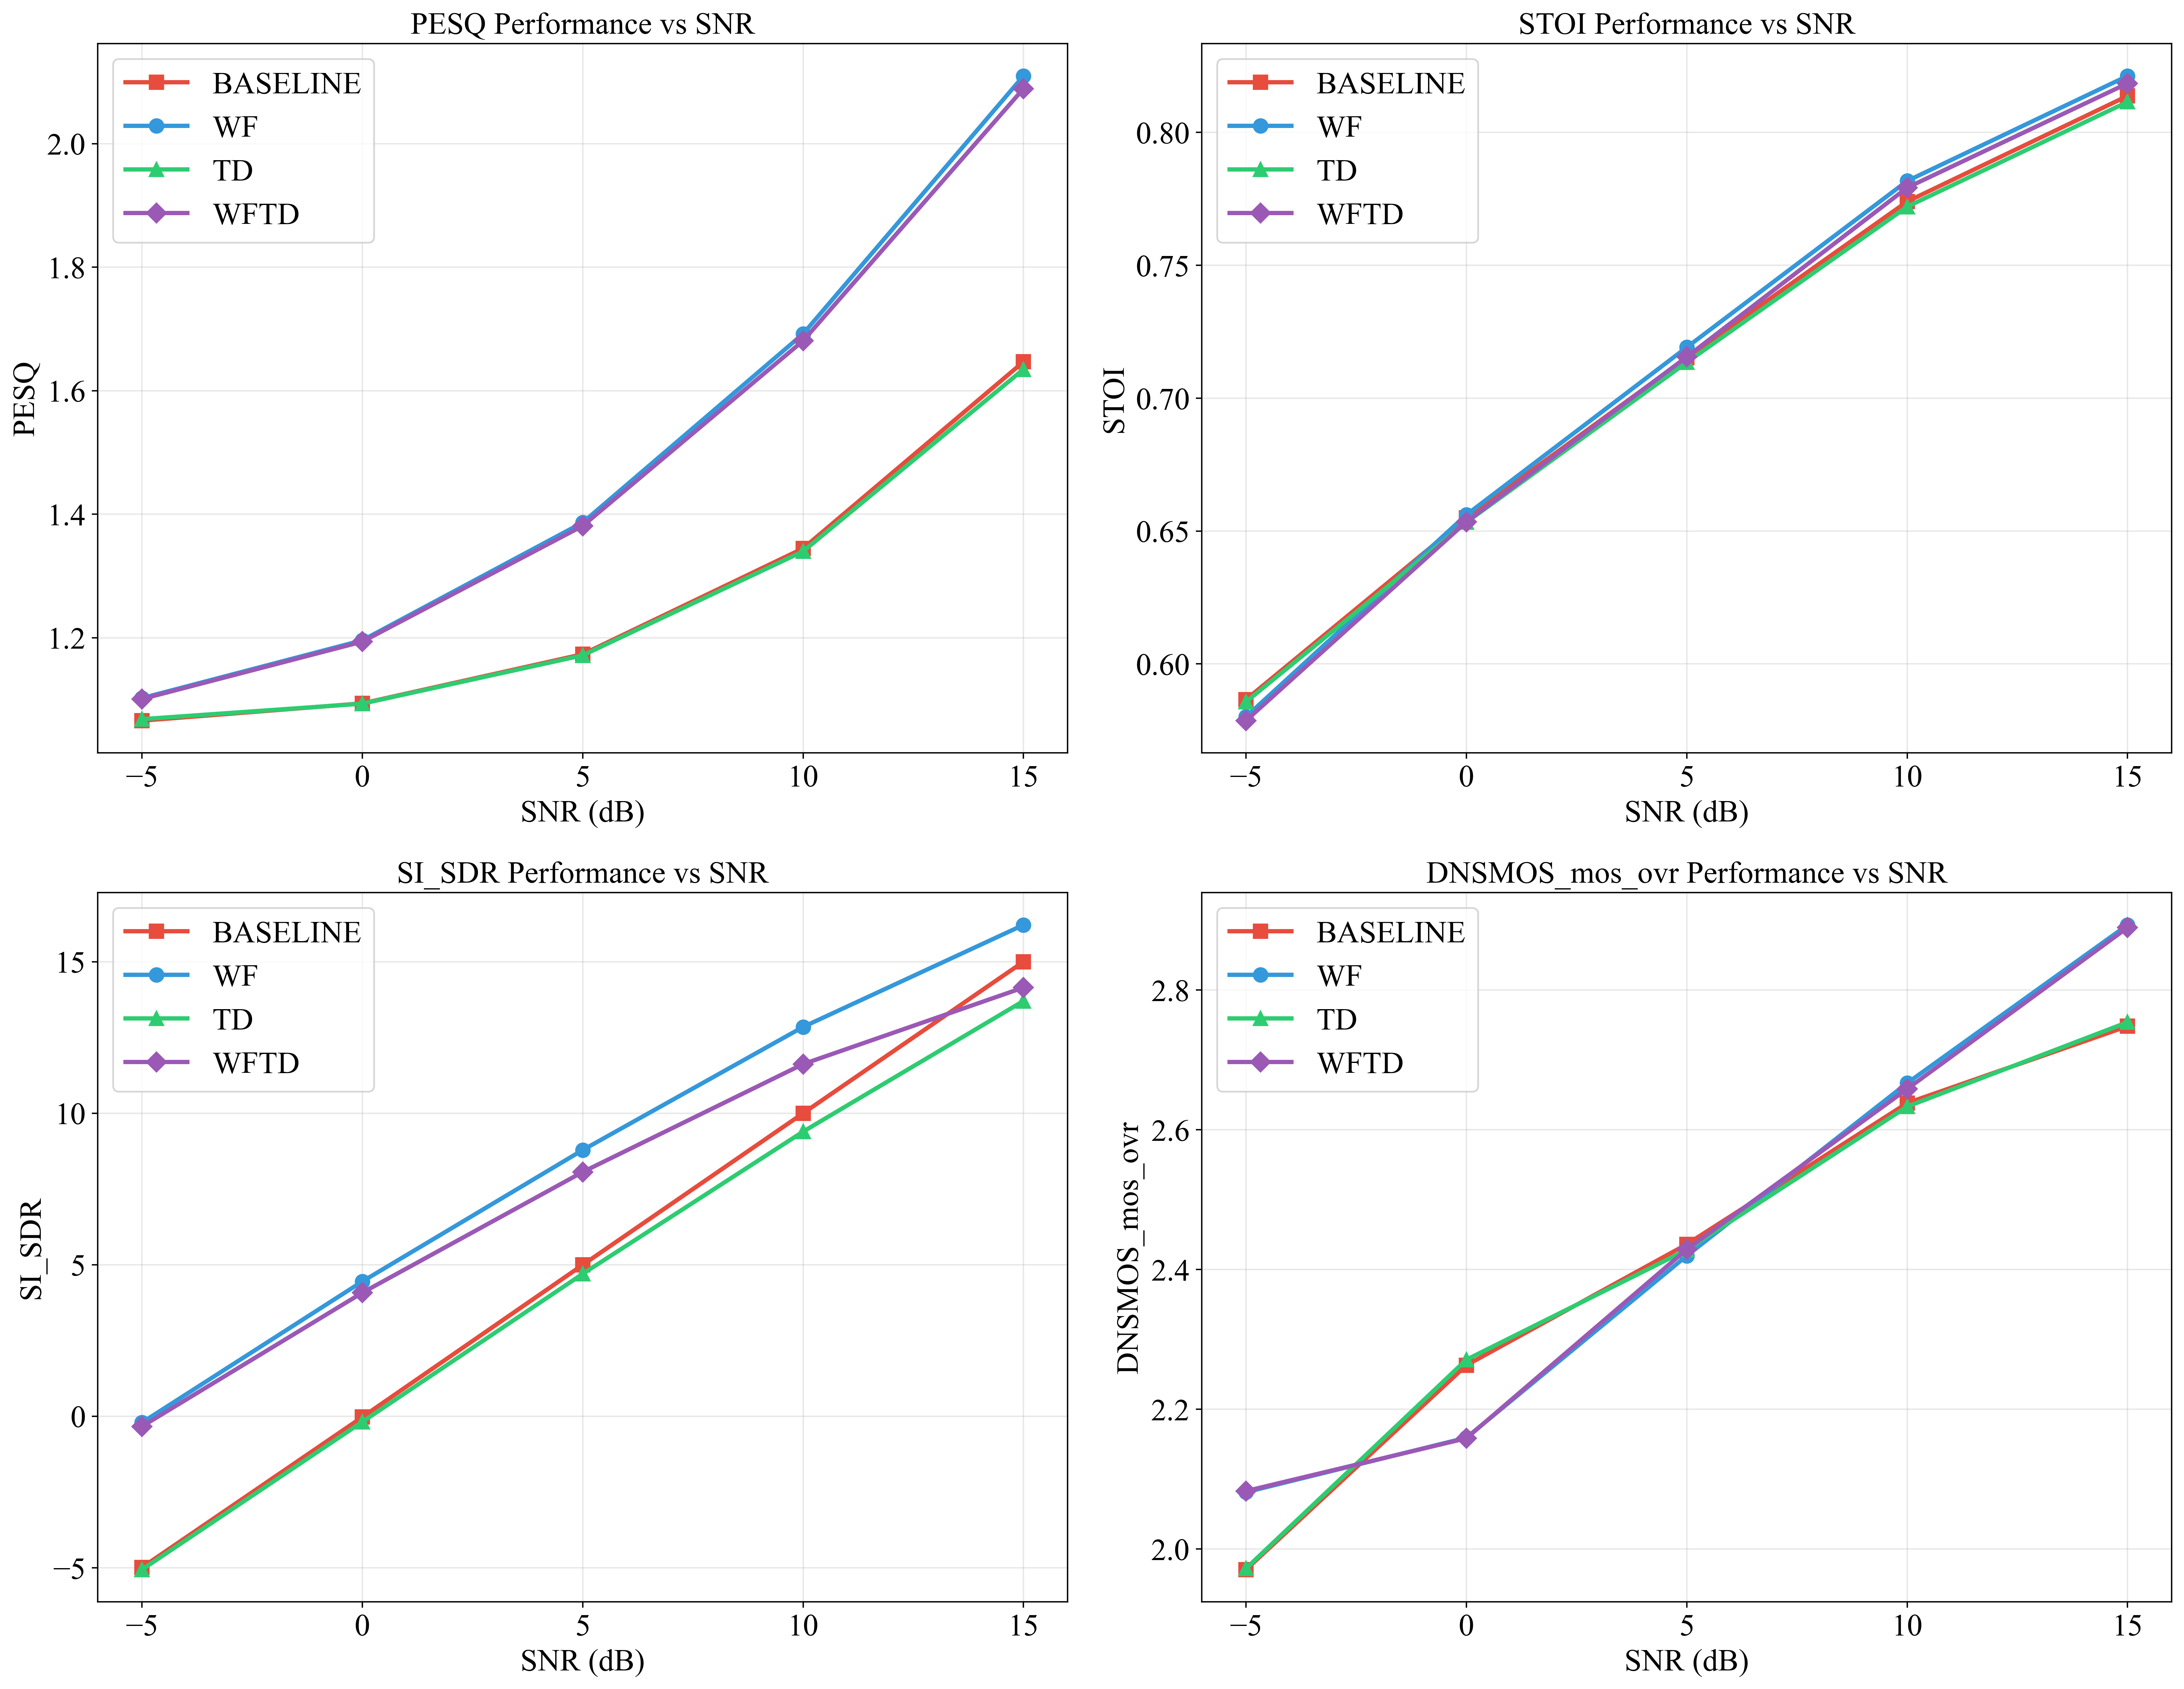

In [61]:
# Visualize performance across SNR levels
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

colors = {
    'BASELINE': '#e74c3c',
    'WF': '#3498db',
    'TD': '#2ecc71',
    'WFTD': '#9b59b6'
}

markers = {
    'BASELINE': 's',
    'WF': 'o',
    'TD': '^',
    'WFTD': 'D'
}

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    metric_data = comparison_df[comparison_df['Metric'] == metric]
    
    for method in ['BASELINE', 'WF', 'TD', 'WFTD']:
        ax.plot(metric_data['SNR'], metric_data[method], 
                marker=markers[method], label=method, 
                color=colors[method], linewidth=2.5, markersize=8)
    
    ax.set_xlabel('SNR (dB)')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Performance vs SNR')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(snr_levels)

plt.tight_layout()
plt.savefig(repo_root / 'reports' / 'figures' / 'EXP3_performance_comparison.png', 
            dpi=400, bbox_inches='tight')
plt.show()

## 3. Percentage Improvements

Calculate percentage improvements of each enhancement method compared to baseline.

In [62]:
# Calculate percentage improvements over baseline
improvement_data = []

for snr in snr_levels:
    baseline = parse_baseline_csv(snr)
    wf = parse_wf_exp1p1d_csv(snr)
    td = parse_td_alone_csv(snr)
    wftd = parse_wftd_csv(snr)
    
    for metric in metrics:
        baseline_val = baseline[metric].mean()
        wf_val = wf[metric].mean()
        td_val = td[metric].mean()
        wftd_val = wftd[metric].mean()
        
        # Calculate percentage improvement
        wf_improve = ((wf_val - baseline_val) / abs(baseline_val)) * 100
        td_improve = ((td_val - baseline_val) / abs(baseline_val)) * 100
        wftd_improve = ((wftd_val - baseline_val) / abs(baseline_val)) * 100
        
        improvement_data.append({
            'SNR': snr,
            'Metric': metric,
            'WF_Improvement_%': wf_improve,
            'TD_Improvement_%': td_improve,
            'WFTD_Improvement_%': wftd_improve
        })

improvement_df = pd.DataFrame(improvement_data)
print("Percentage Improvements Over Baseline:")
print(improvement_df.to_string(index=False))

Percentage Improvements Over Baseline:
 SNR         Metric  WF_Improvement_%  TD_Improvement_%  WFTD_Improvement_%
  -5           PESQ          3.422556          0.230477            3.290189
  -5           STOI         -1.102679         -0.142408           -1.349577
  -5         SI_SDR         95.810169         -1.404137           93.301793
  -5 DNSMOS_mos_ovr          5.625078          0.082509            5.705587
   0           PESQ          9.332640         -0.043412            9.140624
   0           STOI          0.180485         -0.247085           -0.220020
   0         SI_SDR      17041.160406       -598.574549        15627.407413
   0 DNSMOS_mos_ovr         -4.581974          0.350399           -4.616704
   5           PESQ         18.174466         -0.150468           17.716224
   5           STOI          0.543864         -0.247093            0.039740
   5         SI_SDR         75.877610         -5.909840           61.373664
   5 DNSMOS_mos_ovr         -0.671274         -0.

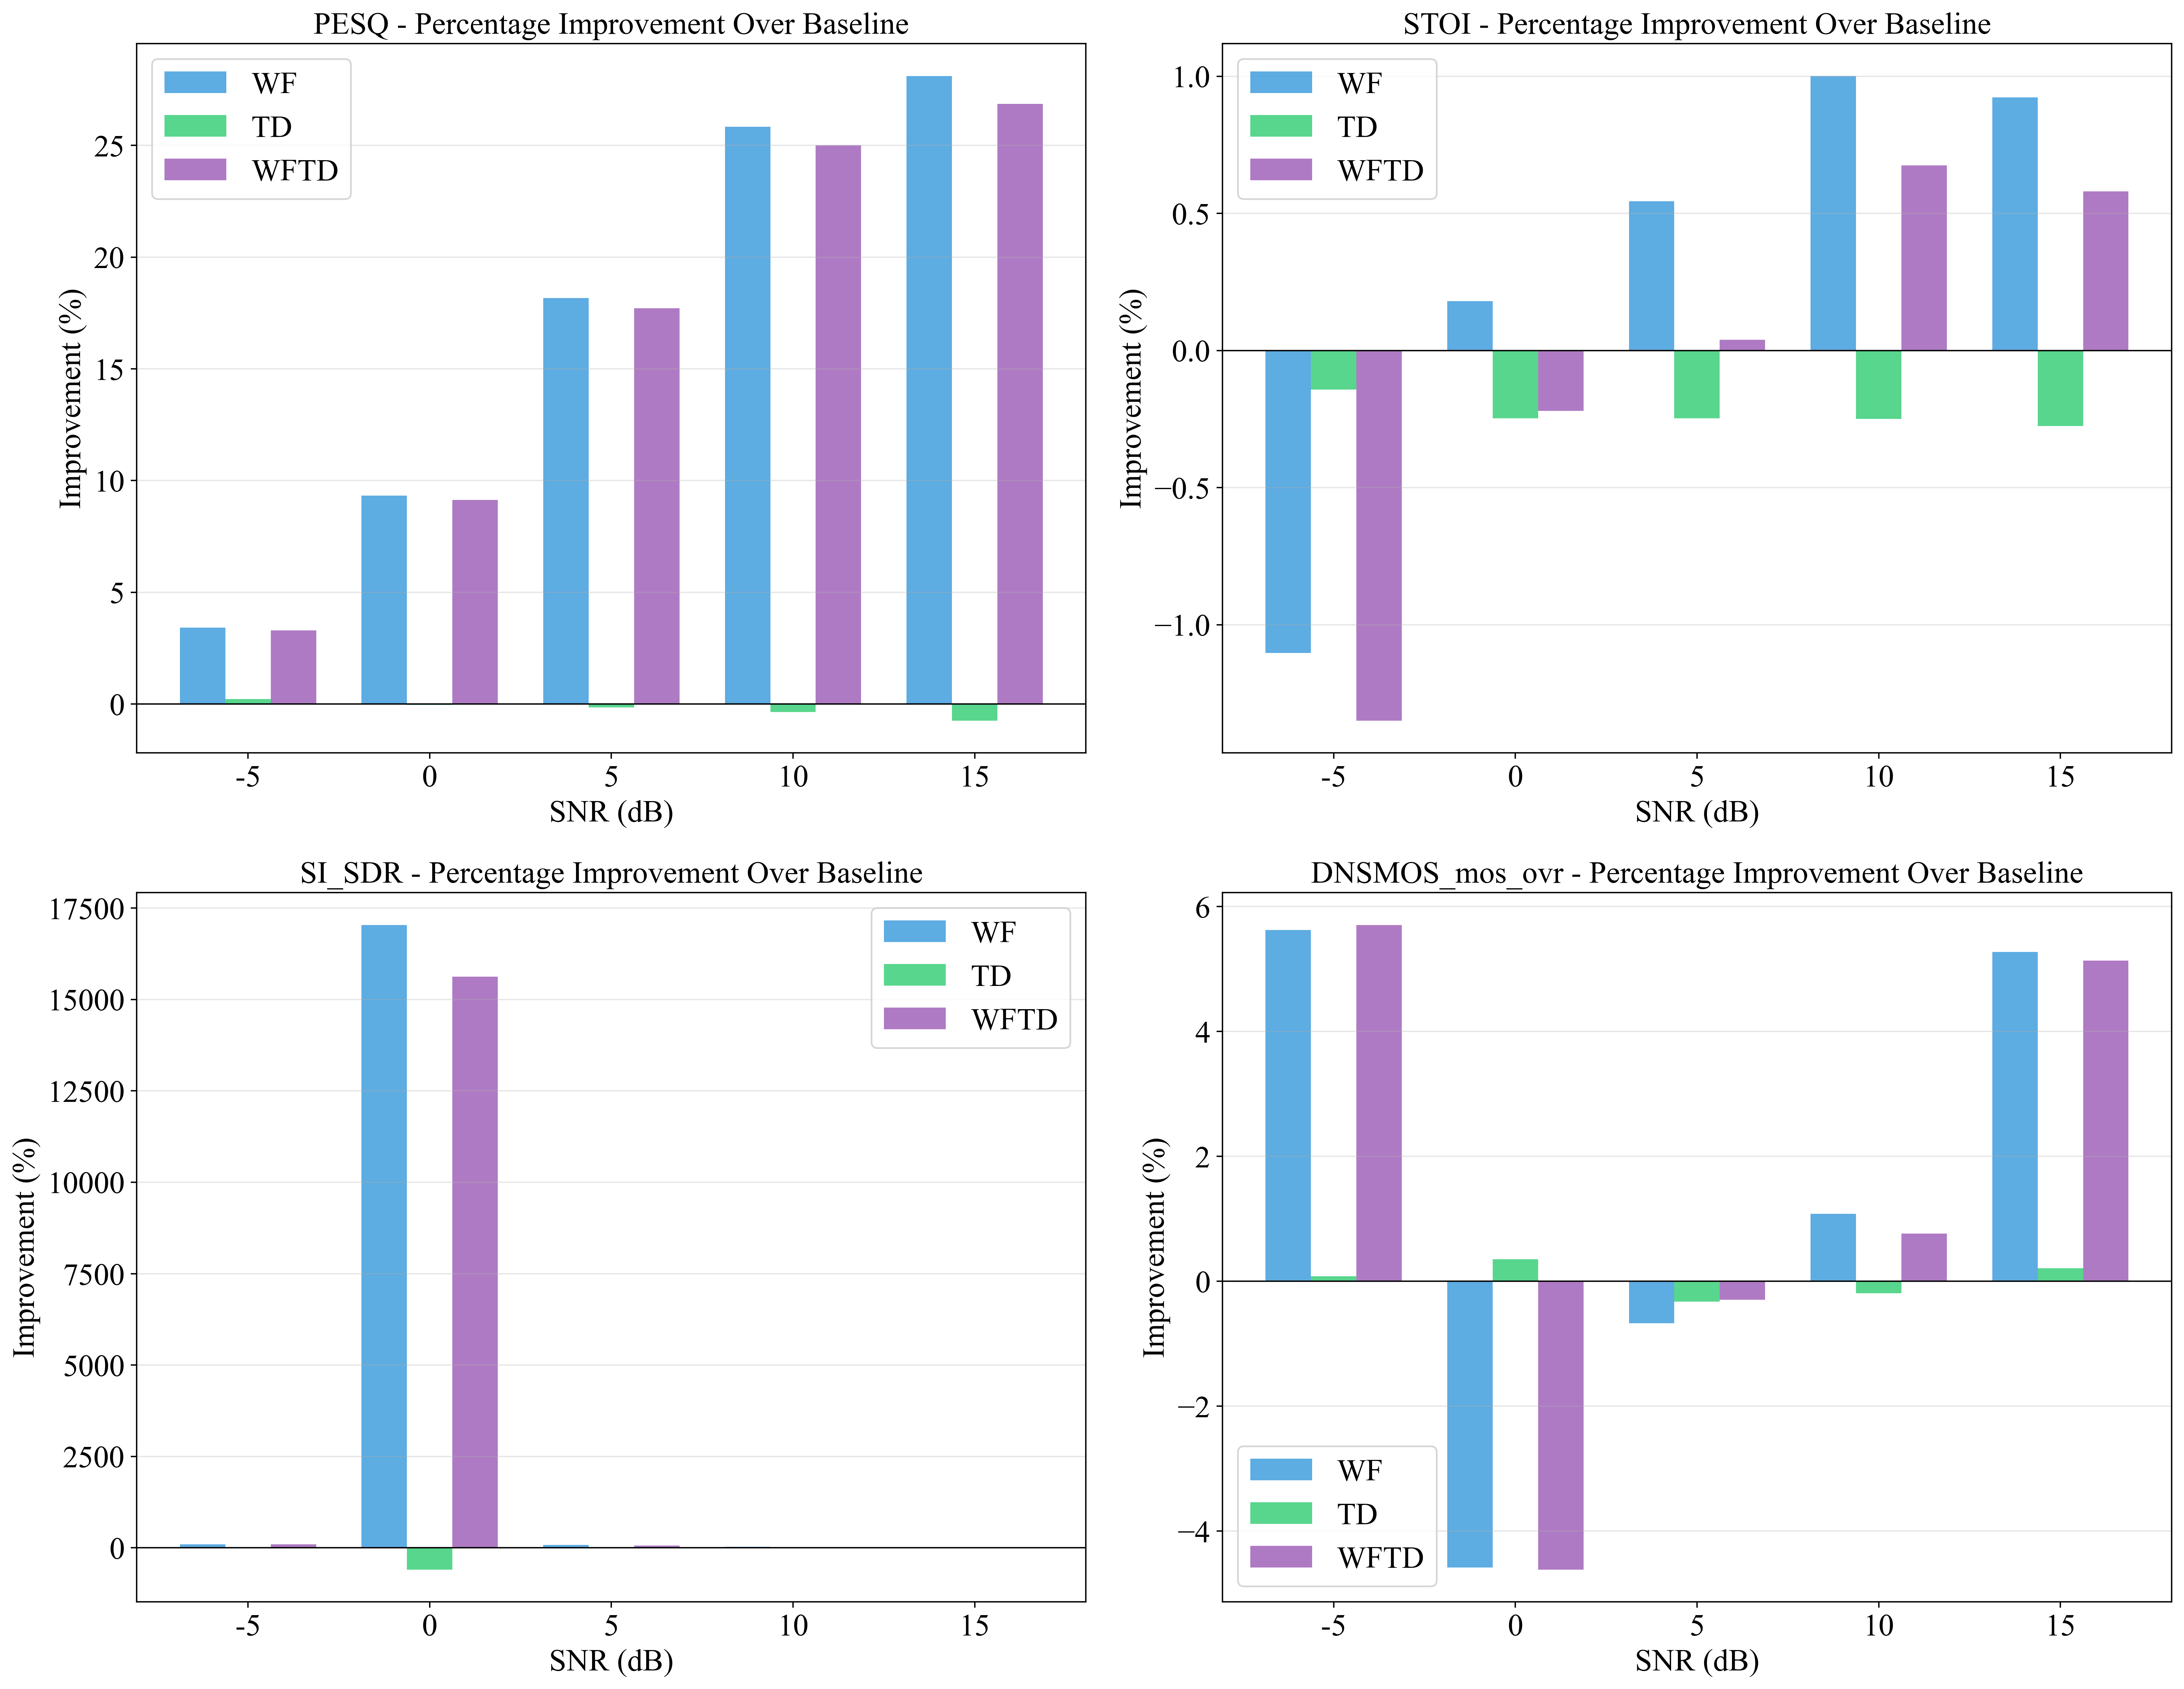

In [63]:
# Visualize percentage improvements
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

colors_improve = {
    'WF_Improvement_%': '#3498db',
    'TD_Improvement_%': '#2ecc71',
    'WFTD_Improvement_%': '#9b59b6'
}

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    metric_data = improvement_df[improvement_df['Metric'] == metric]
    
    x = np.arange(len(snr_levels))
    width = 0.25
    
    ax.bar(x - width, metric_data['WF_Improvement_%'], width, 
           label='WF', color=colors_improve['WF_Improvement_%'], alpha=0.8)
    ax.bar(x, metric_data['TD_Improvement_%'], width, 
           label='TD', color=colors_improve['TD_Improvement_%'], alpha=0.8)
    ax.bar(x + width, metric_data['WFTD_Improvement_%'], width, 
           label='WFTD', color=colors_improve['WFTD_Improvement_%'], alpha=0.8)
    
    ax.set_xlabel('SNR (dB)')
    ax.set_ylabel('Improvement (%)')
    ax.set_title(f'{metric} - Percentage Improvement Over Baseline')
    ax.set_xticks(x)
    ax.set_xticklabels(snr_levels)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.savefig(repo_root / 'reports' / 'figures' / 'EXP3_percentage_improvements.png', 
            dpi=400, bbox_inches='tight')
plt.show()

In [64]:
# Summary statistics of improvements
print("\n" + "=" * 80)
print("AVERAGE IMPROVEMENTS ACROSS ALL SNR LEVELS")
print("=" * 80)

avg_improvements = improvement_df.groupby('Metric')[['WF_Improvement_%', 'TD_Improvement_%', 'WFTD_Improvement_%']].mean()
print(avg_improvements.to_string())

print("\n" + "=" * 80)
print("BEST METHOD PER METRIC (Highest Average Improvement)")
print("=" * 80)

for metric in metrics:
    metric_avg = avg_improvements.loc[metric]
    best_method = metric_avg.idxmax()
    best_value = metric_avg.max()
    print(f"{metric:20s}: {best_method:25s} ({best_value:+.2f}%)")
    


AVERAGE IMPROVEMENTS ACROSS ALL SNR LEVELS
                WF_Improvement_%  TD_Improvement_%  WFTD_Improvement_%
Metric                                                                
DNSMOS_mos_ovr          1.345401          0.024287            1.338382
PESQ                   16.974485         -0.211869           16.401999
SI_SDR               3449.887633       -124.115074         3158.526307
STOI                    0.309309         -0.232433           -0.054875

BEST METHOD PER METRIC (Highest Average Improvement)
PESQ                : WF_Improvement_%          (+16.97%)
STOI                : WF_Improvement_%          (+0.31%)
SI_SDR              : WF_Improvement_%          (+3449.89%)
DNSMOS_mos_ovr      : WF_Improvement_%          (+1.35%)


## 4. Direct Comparison: WFTD vs Individual Methods

Analyze how the hybrid WFTD approach compares against WF and TD individually.

In [65]:
# Calculate improvement of WFTD over WF and TD
wftd_vs_others = []

for snr in snr_levels:
    wf = parse_wf_exp1p1d_csv(snr)
    td = parse_td_alone_csv(snr)
    wftd = parse_wftd_csv(snr)
    
    for metric in metrics:
        wf_val = wf[metric].mean()
        td_val = td[metric].mean()
        wftd_val = wftd[metric].mean()
        
        # WFTD improvement over WF
        wftd_vs_wf = ((wftd_val - wf_val) / abs(wf_val)) * 100
        # WFTD improvement over TD
        wftd_vs_td = ((wftd_val - td_val) / abs(td_val)) * 100
        
        wftd_vs_others.append({
            'SNR': snr,
            'Metric': metric,
            'WFTD_vs_WF_%': wftd_vs_wf,
            'WFTD_vs_TD_%': wftd_vs_td
        })

wftd_comparison_df = pd.DataFrame(wftd_vs_others)
print("WFTD Improvement Over Individual Methods:")
print(wftd_comparison_df.to_string(index=False))

WFTD Improvement Over Individual Methods:
 SNR         Metric  WFTD_vs_WF_%  WFTD_vs_TD_%
  -5           PESQ     -0.127986      3.052677
  -5           STOI     -0.249652     -1.208891
  -5         SI_SDR    -59.868190     93.394542
  -5 DNSMOS_mos_ovr      0.076221      5.618442
   0           PESQ     -0.175626      9.188024
   0           STOI     -0.399783      0.027132
   0         SI_SDR     -8.345078   2322.727328
   0 DNSMOS_mos_ovr     -0.036397     -4.949759
   5           PESQ     -0.387767     17.893616
   5           STOI     -0.501397      0.287543
   5         SI_SDR     -8.246613     71.509607
   5 DNSMOS_mos_ovr      0.375517      0.028276
  10           PESQ     -0.661696     25.448897
  10           STOI     -0.322656      0.927590
  10         SI_SDR     -9.544500     23.719192
  10 DNSMOS_mos_ovr     -0.311963      0.960216
  15           PESQ     -0.973528     27.806385
  15           STOI     -0.340360      0.858159
  15         SI_SDR    -12.745155      3.23216

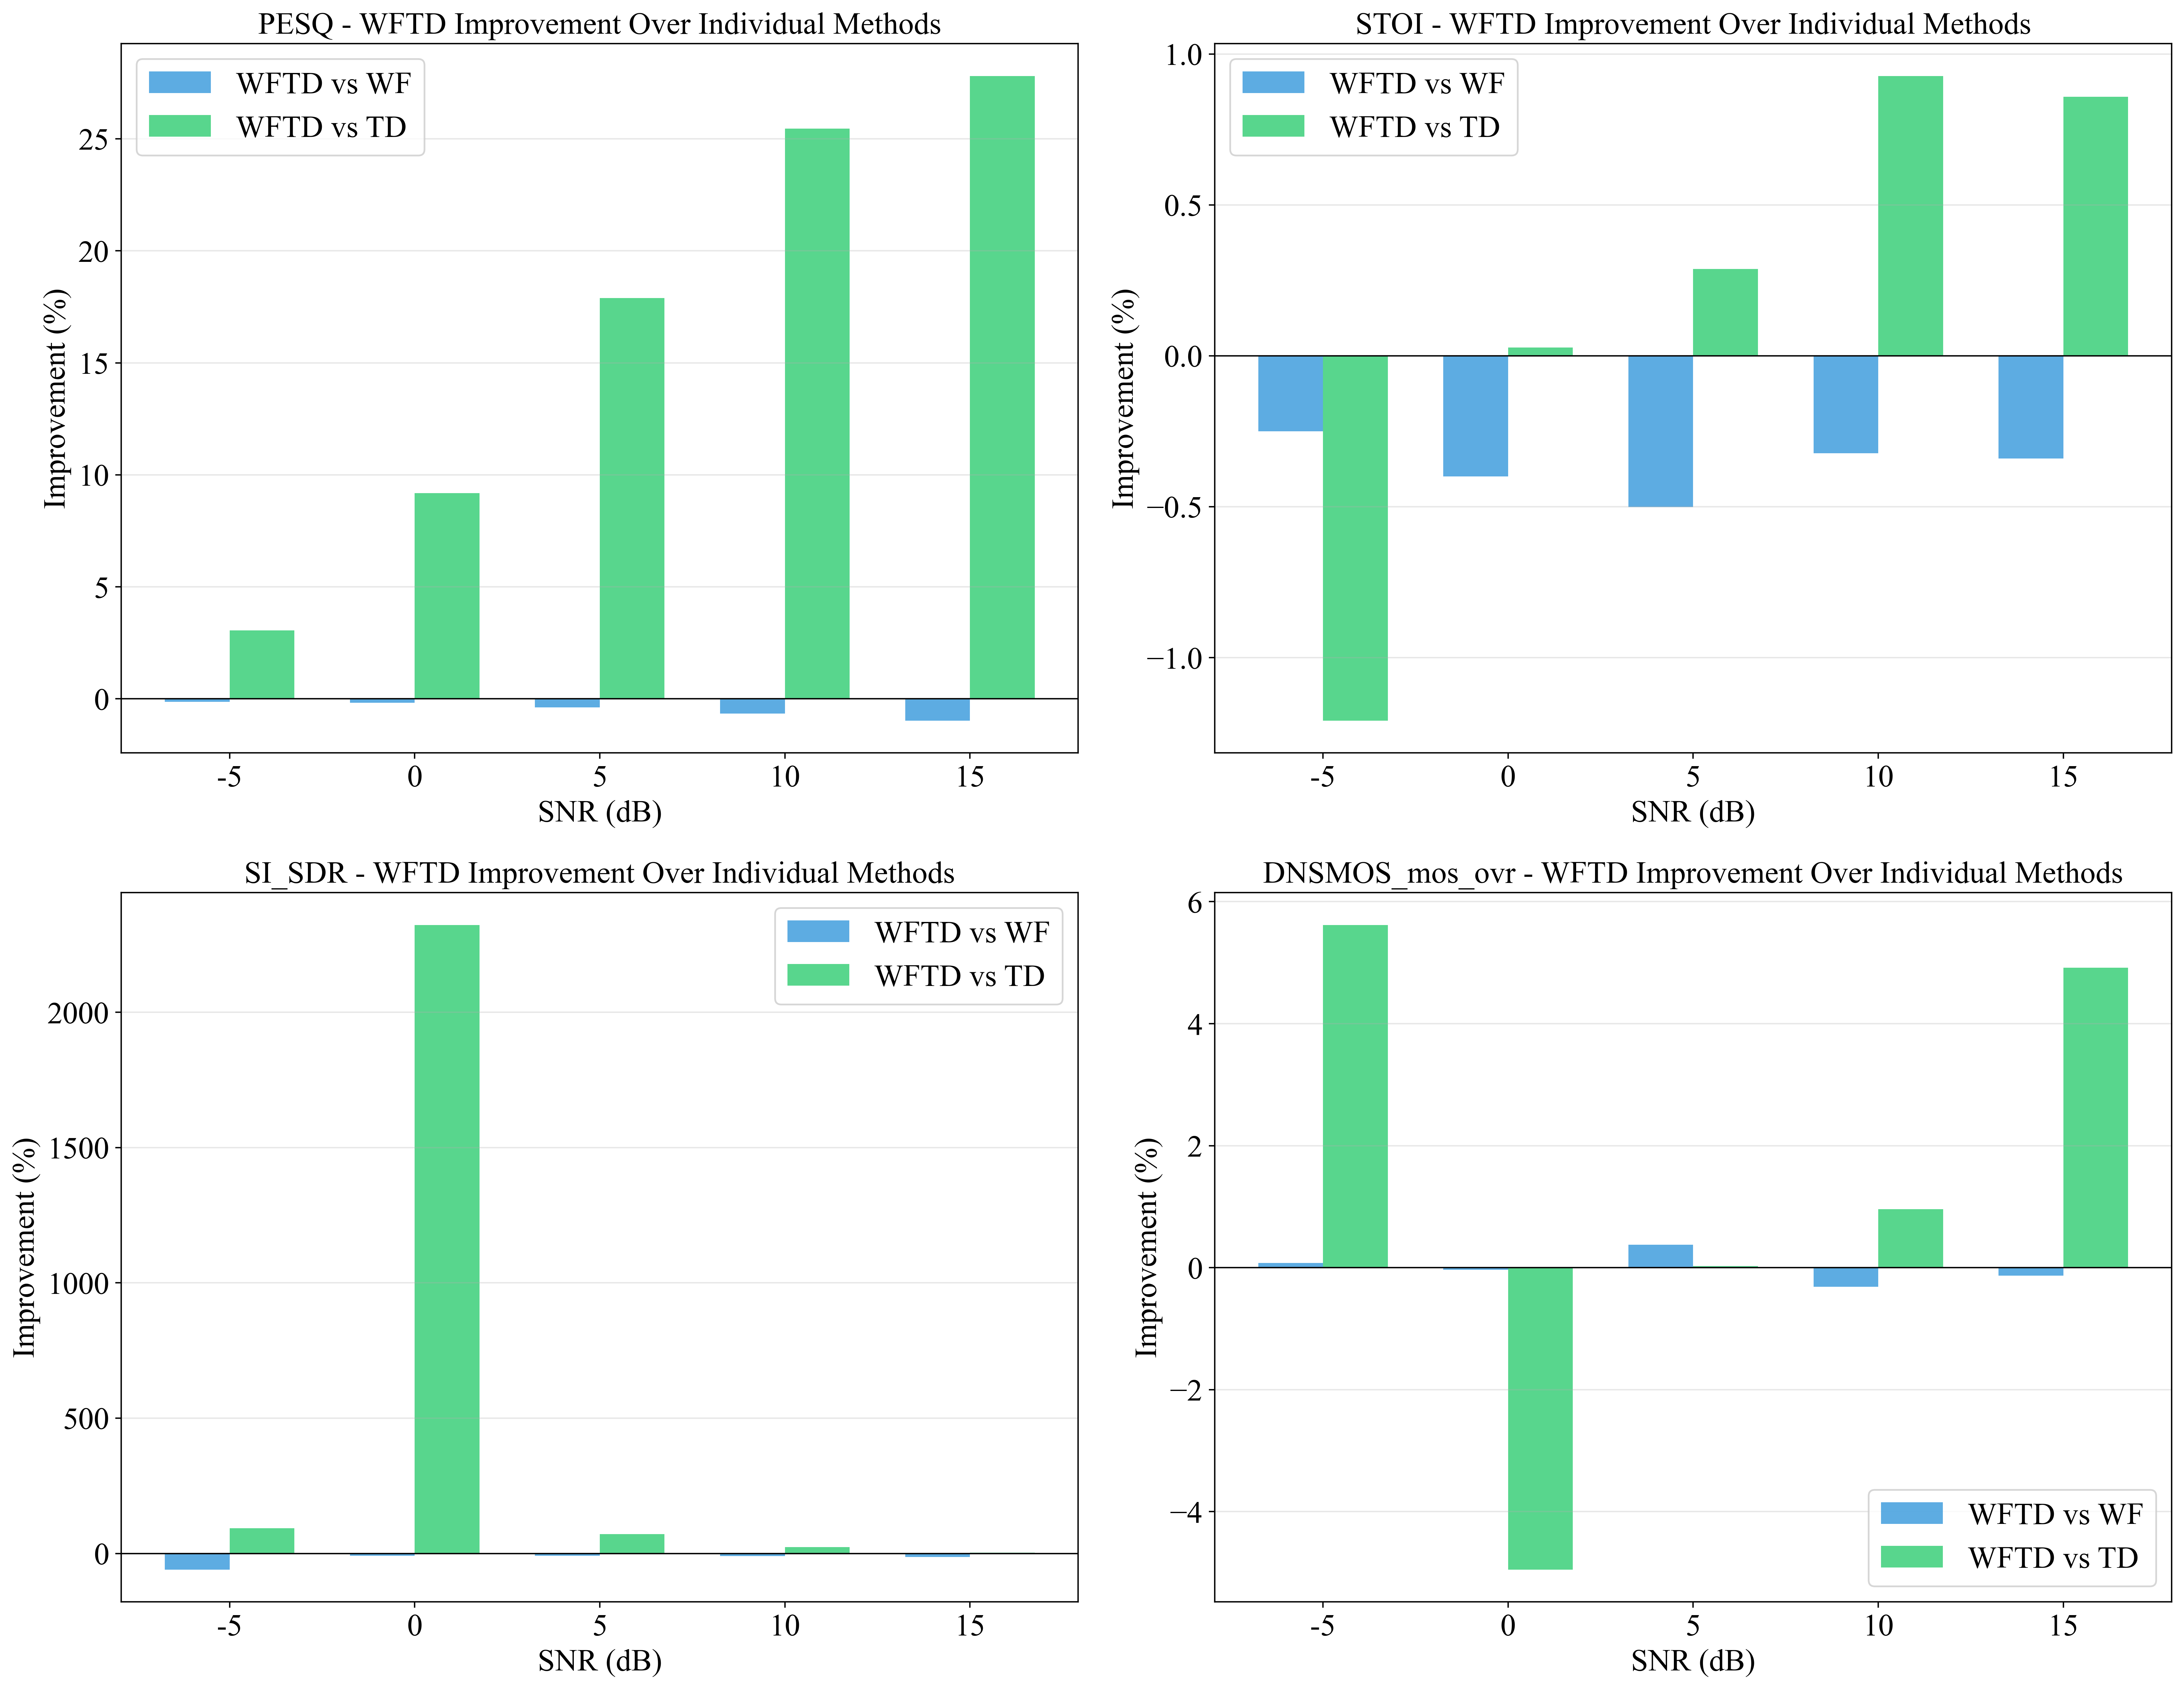

In [66]:
# Visualize WFTD vs individual methods
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    metric_data = wftd_comparison_df[wftd_comparison_df['Metric'] == metric]
    
    x = np.arange(len(snr_levels))
    width = 0.35
    
    ax.bar(x - width/2, metric_data['WFTD_vs_WF_%'], width, 
           label='WFTD vs WF', color='#3498db', alpha=0.8)
    ax.bar(x + width/2, metric_data['WFTD_vs_TD_%'], width, 
           label='WFTD vs TD', color='#2ecc71', alpha=0.8)
    
    ax.set_xlabel('SNR (dB)')
    ax.set_ylabel('Improvement (%)')
    ax.set_title(f'{metric} - WFTD Improvement Over Individual Methods')
    ax.set_xticks(x)
    ax.set_xticklabels(snr_levels)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.savefig(repo_root / 'reports' / 'figures' / 'EXP3_wftd_vs_individual.png', 
            dpi=400, bbox_inches='tight')
plt.show()

In [67]:
# Average improvements of WFTD over individual methods
print("\n" + "=" * 80)
print("AVERAGE WFTD IMPROVEMENTS OVER INDIVIDUAL METHODS")
print("=" * 80)

wftd_avg = wftd_comparison_df.groupby('Metric')[['WFTD_vs_WF_%', 'WFTD_vs_TD_%']].mean()
print(wftd_avg.to_string())

print("\n" + "=" * 80)
print("SYNERGY ANALYSIS")
print("=" * 80)
print("\nFor each metric, comparing if WFTD (hybrid) outperforms both individual methods:")
print()

for metric in metrics:
    avg_wf = wftd_avg.loc[metric, 'WFTD_vs_WF_%']
    avg_td = wftd_avg.loc[metric, 'WFTD_vs_TD_%']
    
    if avg_wf > 0 and avg_td > 0:
        status = "✓ WFTD outperforms BOTH"
        color = "positive synergy"
    elif avg_wf > 0 or avg_td > 0:
        status = "~ WFTD outperforms ONE"
        color = "partial benefit"
    else:
        status = "✗ WFTD underperforms BOTH"
        color = "no synergy"
    
    print(f"{metric:20s}: {status:30s} (vs WF: {avg_wf:+.2f}%, vs TD: {avg_td:+.2f}%)")
    


AVERAGE WFTD IMPROVEMENTS OVER INDIVIDUAL METHODS
                WFTD_vs_WF_%  WFTD_vs_TD_%
Metric                                    
DNSMOS_mos_ovr     -0.005643      1.314984
PESQ               -0.465320     16.677920
SI_SDR            -19.749907    502.916567
STOI               -0.362770      0.178307

SYNERGY ANALYSIS

For each metric, comparing if WFTD (hybrid) outperforms both individual methods:

PESQ                : ~ WFTD outperforms ONE         (vs WF: -0.47%, vs TD: +16.68%)
STOI                : ~ WFTD outperforms ONE         (vs WF: -0.36%, vs TD: +0.18%)
SI_SDR              : ~ WFTD outperforms ONE         (vs WF: -19.75%, vs TD: +502.92%)
DNSMOS_mos_ovr      : ~ WFTD outperforms ONE         (vs WF: -0.01%, vs TD: +1.31%)


## 5. Performance by Noise Type

Analyze how each method performs across different noise types.

In [68]:
# Compile data by noise type for SNR = 5dB
snr_test = 5

baseline_noise = parse_baseline_csv(snr_test)
wf_noise = parse_wf_exp1p1d_csv(snr_test)
td_noise = parse_td_alone_csv(snr_test)
wftd_noise = parse_wftd_csv(snr_test)

# Get noise types
noise_types = baseline_noise.index.tolist()

# Create comparison for each metric
noise_comparison = []
for noise in noise_types:
    for metric in metrics:
        noise_comparison.append({
            'Noise_Type': noise,
            'Metric': metric,
            'BASELINE': baseline_noise.loc[noise, metric],
            'WF': wf_noise.loc[noise, metric],
            'TD': td_noise.loc[noise, metric],
            'WFTD': wftd_noise.loc[noise, metric]
        })

noise_df = pd.DataFrame(noise_comparison)

# Display sample results
print(f"Performance by Noise Type at {snr_test}dB SNR:")
print(noise_df[noise_df['Metric'] == 'PESQ'].to_string(index=False))

Performance by Noise Type at 5dB SNR:
                   Noise_Type Metric  BASELINE       WF       TD     WFTD
              Car Noise_60mph   PESQ  1.180366 1.504133 1.180354 1.504135
   Car Noise_Idle Noise_40mph   PESQ  1.097002 1.448803 1.096678 1.446973
   Car Noise_Idle Noise_60mph   PESQ  1.179675 1.482966 1.181125 1.482897
    Construction_Crane_Moving   PESQ  1.061834 1.075124 1.058822 1.066653
        Construction_Drilling   PESQ  1.089196 1.252827 1.088792 1.248116
     Construction_Jackhammer1   PESQ  1.142452 1.244302 1.138224 1.231152
     Construction_Jackhammer2   PESQ  1.151147 1.235540 1.133867 1.199396
Construction_Trucks_Unloading   PESQ  1.136241 1.484212 1.136077 1.475492
                Inside Flight   PESQ  1.348175 1.518040 1.348072 1.518026
               Inside Train_1   PESQ  1.144642 1.196040 1.144641 1.196041
               Inside Train_2   PESQ  1.228126 1.604034 1.228140 1.604043
               Inside Train_3   PESQ  1.111084 1.278067 1.107301 1.267868


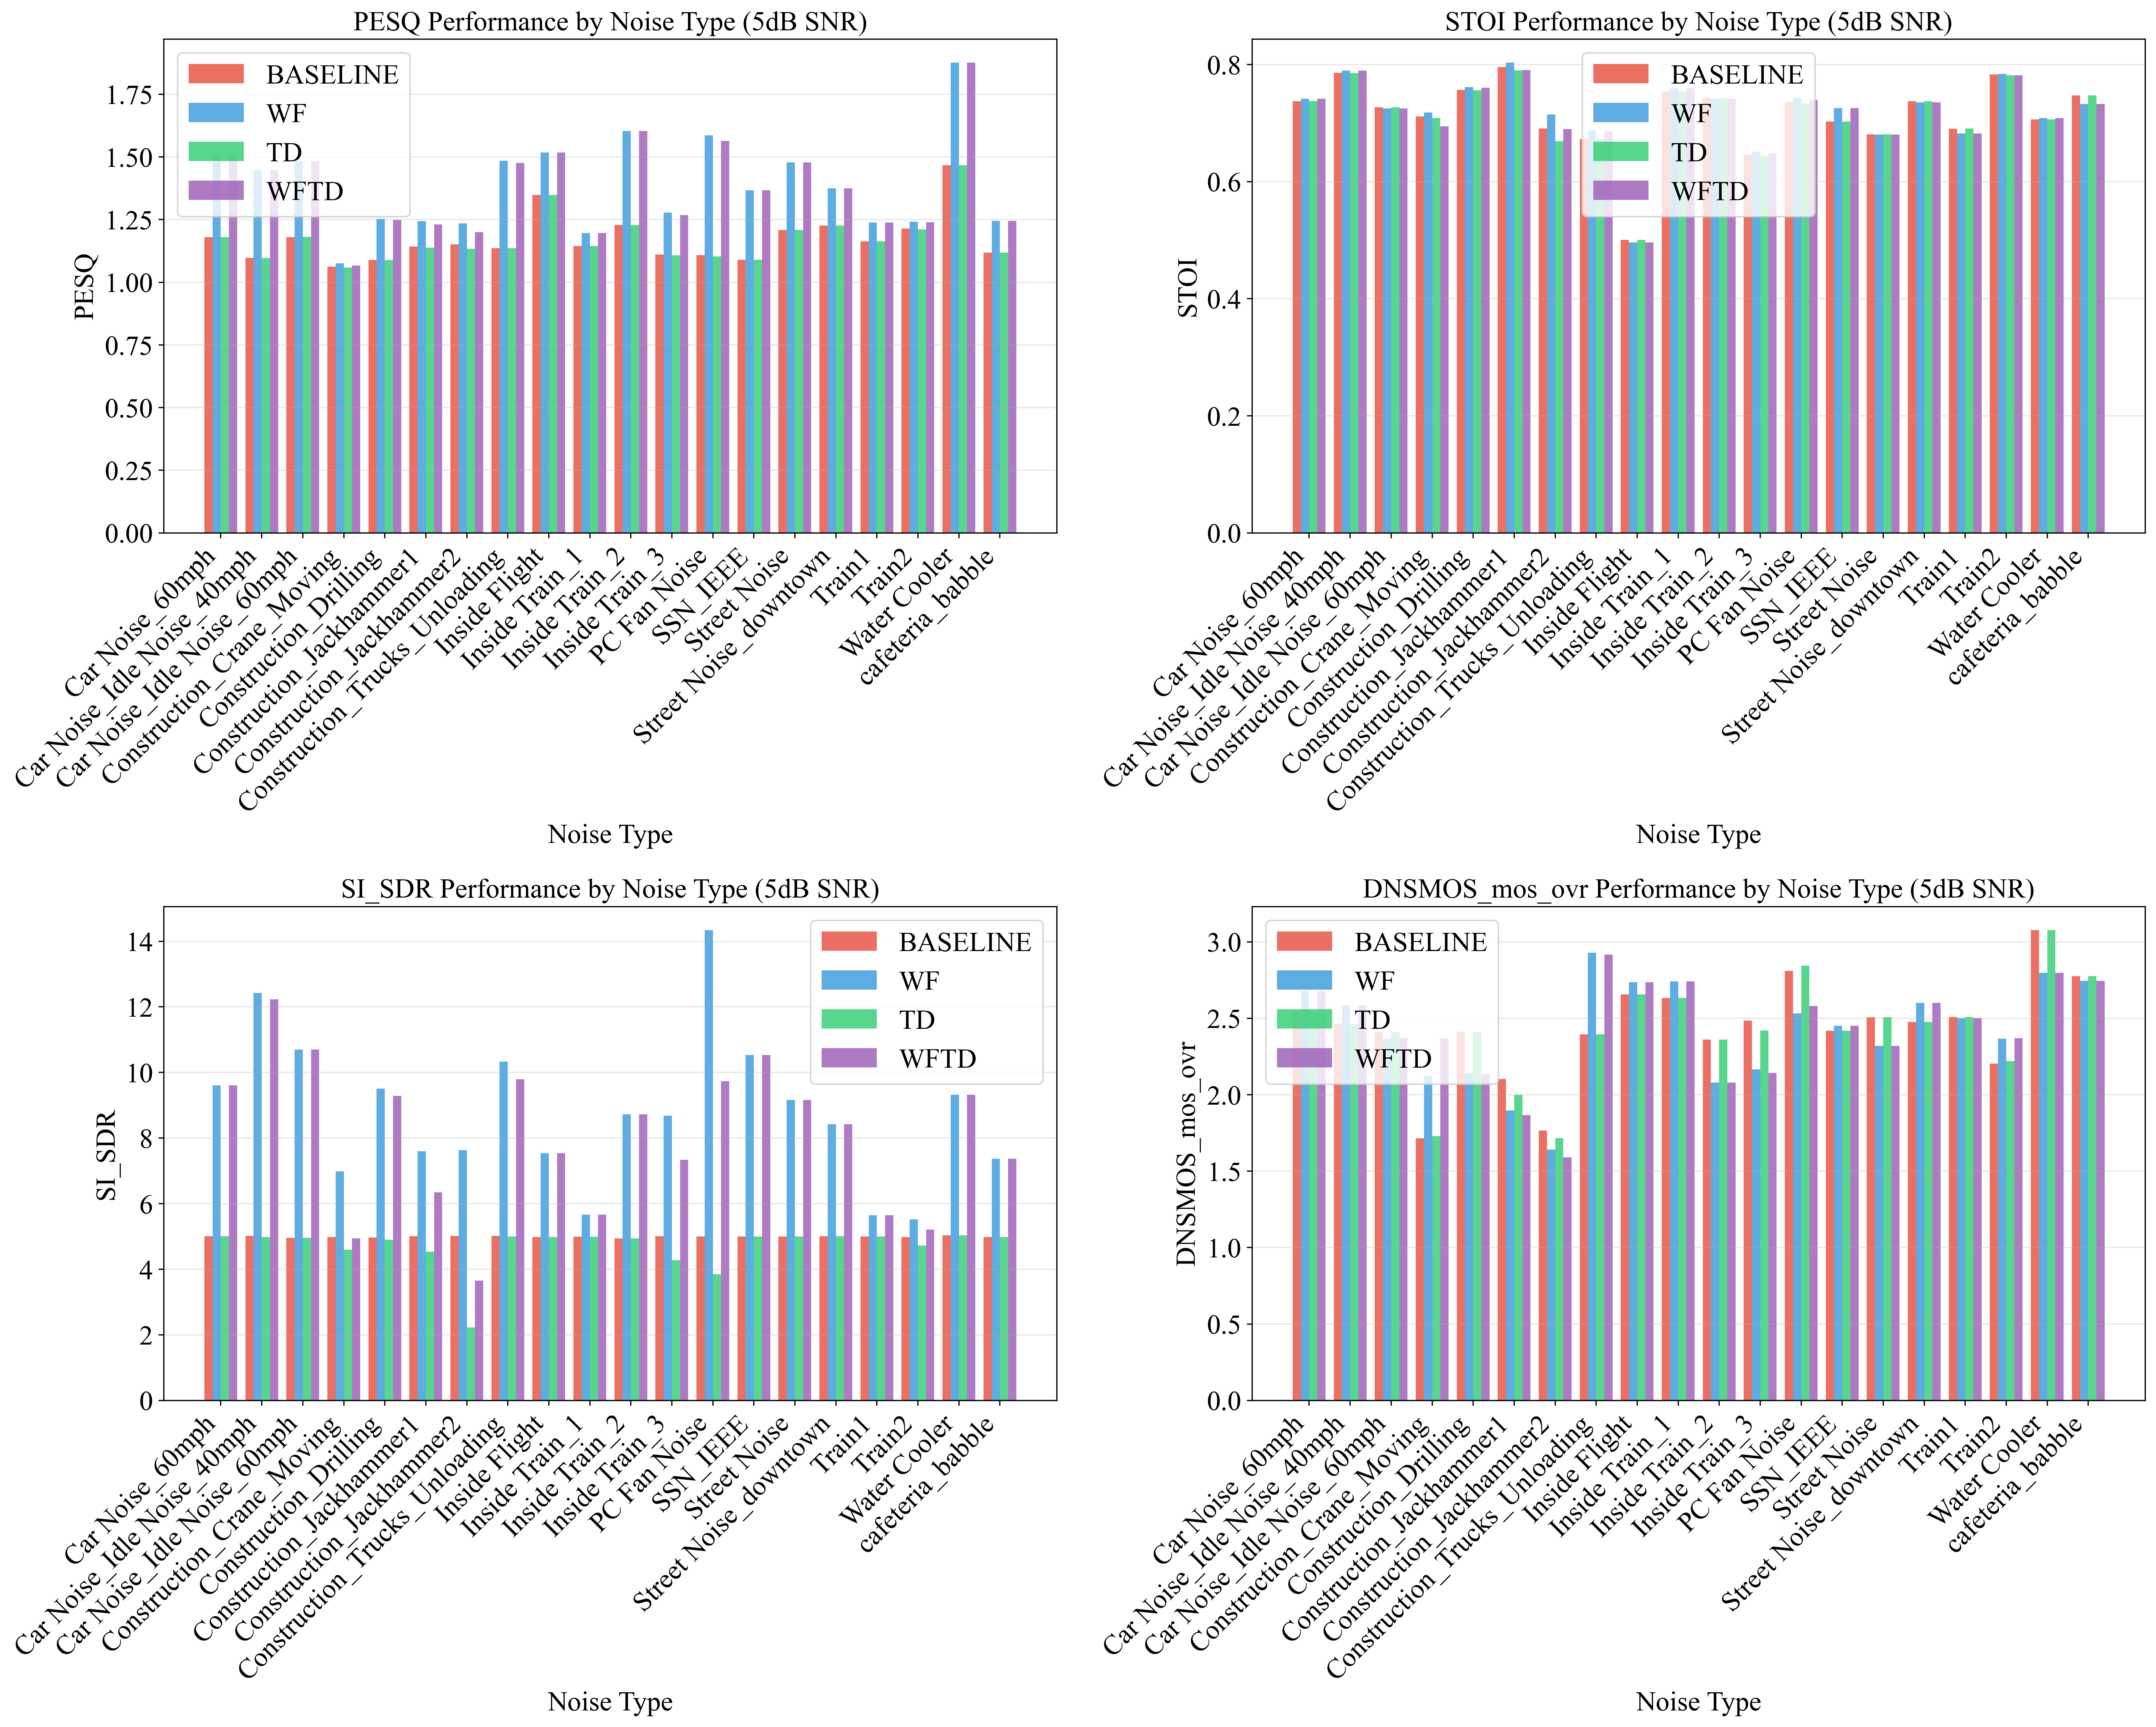

In [69]:
# Visualize performance by noise type
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    metric_data = noise_df[noise_df['Metric'] == metric]
    
    x = np.arange(len(noise_types))
    width = 0.2
    
    ax.bar(x - 1.5*width, metric_data['BASELINE'], width, 
           label='BASELINE', color='#e74c3c', alpha=0.8)
    ax.bar(x - 0.5*width, metric_data['WF'], width, 
           label='WF', color='#3498db', alpha=0.8)
    ax.bar(x + 0.5*width, metric_data['TD'], width, 
           label='TD', color='#2ecc71', alpha=0.8)
    ax.bar(x + 1.5*width, metric_data['WFTD'], width, 
           label='WFTD', color='#9b59b6', alpha=0.8)
    
    ax.set_xlabel('Noise Type')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Performance by Noise Type ({snr_test}dB SNR)')
    ax.set_xticks(x)
    ax.set_xticklabels(noise_types, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(repo_root / 'reports' / 'figures' / f'EXP3_noise_type_comparison_{snr_test}dB.png', 
            dpi=400, bbox_inches='tight')
plt.show()

## 6. Statistical Summary Tables

Generate comprehensive tables for reporting.

In [70]:
# Create pivot tables for each metric
for metric in metrics:
    print("\n" + "=" * 80)
    print(f"{metric} Performance Summary")
    print("=" * 80)
    
    pivot_data = comparison_df[comparison_df['Metric'] == metric].copy()
    pivot_data = pivot_data.set_index('SNR')
    pivot_data = pivot_data[['BASELINE', 'WF', 'TD', 'WFTD']]
    
    print(pivot_data.to_string())
    print(f"\nOverall Average: BASELINE={pivot_data['BASELINE'].mean():.4f}, "
          f"WF={pivot_data['WF'].mean():.4f}, "
          f"TD={pivot_data['TD'].mean():.4f}, "
          f"WFTD={pivot_data['WFTD'].mean():.4f}")


PESQ Performance Summary
     BASELINE        WF        TD      WFTD
SNR                                        
-5   1.065751  1.102227  1.068207  1.100816
 0   1.093715  1.195787  1.093240  1.193687
 5   1.173282  1.386520  1.171517  1.381143
 10  1.344649  1.692061  1.339880  1.680865
 15  1.646841  2.109705  1.634634  2.089166

Overall Average: BASELINE=1.2648, WF=1.4973, TD=1.2615, WFTD=1.4891

STOI Performance Summary
     BASELINE        WF        TD      WFTD
SNR                                        
-5   0.586570  0.580102  0.585735  0.578654
 0   0.654918  0.656100  0.653300  0.653477
 5   0.715255  0.719145  0.713487  0.715539
 10  0.773980  0.781729  0.772046  0.779207
 15  0.813742  0.821258  0.811498  0.818462

Overall Average: BASELINE=0.7089, WF=0.7117, TD=0.7072, WFTD=0.7091

SI_SDR Performance Summary
      BASELINE         WF         TD       WFTD
SNR                                            
-5   -4.989893  -0.209068  -5.059958  -0.334233
 0   -0.026259   4.448

## 7. Key Findings and Conclusions

Summary of the experiment results.

In [71]:
# Generate comprehensive findings report
print("=" * 100)
print(" " * 30 + "EXPERIMENT 3 - KEY FINDINGS")
print("=" * 100)

print("\n1. OVERALL PERFORMANCE RANKING (Average across all SNR levels)")
print("-" * 100)

overall_scores = {}
for method in ['BASELINE', 'WF', 'TD', 'WFTD']:
    method_scores = []
    for metric in metrics:
        metric_data = comparison_df[comparison_df['Metric'] == metric]
        avg_score = metric_data[method].mean()
        method_scores.append(avg_score)
    overall_scores[method] = method_scores

# Create ranking for each metric
for idx, metric in enumerate(metrics):
    scores = {method: overall_scores[method][idx] for method in ['BASELINE', 'WF', 'TD', 'WFTD']}
    sorted_methods = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\n{metric}:")
    for rank, (method, score) in enumerate(sorted_methods, 1):
        print(f"  {rank}. {method:12s}: {score:.4f}")

print("\n\n2. PERCENTAGE IMPROVEMENTS SUMMARY")
print("-" * 100)

for metric in metrics:
    metric_improve = improvement_df[improvement_df['Metric'] == metric]
    avg_wf = metric_improve['WF_Improvement_%'].mean()
    avg_td = metric_improve['TD_Improvement_%'].mean()
    avg_wftd = metric_improve['WFTD_Improvement_%'].mean()
    
    print(f"\n{metric}:")
    print(f"  WF improvement over BASELINE:   {avg_wf:+.2f}%")
    print(f"  TD improvement over BASELINE:   {avg_td:+.2f}%")
    print(f"  WFTD improvement over BASELINE: {avg_wftd:+.2f}%")

print("\n\n3. HYBRID APPROACH EFFECTIVENESS")
print("-" * 100)

for metric in metrics:
    metric_wftd = wftd_comparison_df[wftd_comparison_df['Metric'] == metric]
    avg_vs_wf = metric_wftd['WFTD_vs_WF_%'].mean()
    avg_vs_td = metric_wftd['WFTD_vs_TD_%'].mean()
    
    print(f"\n{metric}:")
    print(f"  WFTD vs WF: {avg_vs_wf:+.2f}%")
    print(f"  WFTD vs TD: {avg_vs_td:+.2f}%")
    
    if avg_vs_wf > 0 and avg_vs_td > 0:
        conclusion = "✓ Hybrid approach outperforms both individual methods"
    elif avg_vs_wf > 0:
        conclusion = "~ Hybrid outperforms WF but not TD"
    elif avg_vs_td > 0:
        conclusion = "~ Hybrid outperforms TD but not WF"
    else:
        conclusion = "✗ Individual methods outperform hybrid"
    
    print(f"  Conclusion: {conclusion}")

print("\n" + "=" * 100)

                              EXPERIMENT 3 - KEY FINDINGS

1. OVERALL PERFORMANCE RANKING (Average across all SNR levels)
----------------------------------------------------------------------------------------------------

PESQ:
  1. WF          : 1.4973
  2. WFTD        : 1.4891
  3. BASELINE    : 1.2648
  4. TD          : 1.2615

STOI:
  1. WF          : 0.7117
  2. WFTD        : 0.7091
  3. BASELINE    : 0.7089
  4. TD          : 0.7072

SI_SDR:
  1. WF          : 8.4175
  2. WFTD        : 7.5147
  3. BASELINE    : 4.9955
  4. TD          : 4.5110

DNSMOS_mos_ovr:
  1. WF          : 2.4441
  2. WFTD        : 2.4436
  3. TD          : 2.4117
  4. BASELINE    : 2.4112


2. PERCENTAGE IMPROVEMENTS SUMMARY
----------------------------------------------------------------------------------------------------

PESQ:
  WF improvement over BASELINE:   +16.97%
  TD improvement over BASELINE:   -0.21%
  WFTD improvement over BASELINE: +16.40%

STOI:
  WF improvement over BASELINE:   +0.31%
  T

## 8. Metric Correlations

Analyze correlations between different metrics to understand their relationships and identify redundant vs complementary measurements.

In [72]:
# Compile all metric data across all methods and SNR levels for correlation analysis
correlation_data = []

for snr in snr_levels:
    baseline = parse_baseline_csv(snr)
    wf = parse_wf_exp1p1d_csv(snr)
    td = parse_td_alone_csv(snr)
    wftd = parse_wftd_csv(snr)
    
    # Combine all methods
    for method_name, method_df in [('BASELINE', baseline), ('WF', wf), ('TD', td), ('WFTD', wftd)]:
        for noise_type in method_df.index:
            correlation_data.append({
                'Method': method_name,
                'SNR': snr,
                'Noise_Type': noise_type,
                'PESQ': method_df.loc[noise_type, 'PESQ'],
                'STOI': method_df.loc[noise_type, 'STOI'],
                'SI_SDR': method_df.loc[noise_type, 'SI_SDR'],
                'DNSMOS_mos_ovr': method_df.loc[noise_type, 'DNSMOS_mos_ovr']
            })

correlation_df = pd.DataFrame(correlation_data)

# Compute correlation matrix
correlation_matrix = correlation_df[metrics].corr()

print("=" * 80)
print("METRIC CORRELATION MATRIX")
print("=" * 80)
print(correlation_matrix.to_string())
print("\n")

# Find highly correlated pairs
print("=" * 80)
print("HIGHLY CORRELATED METRIC PAIRS (|r| > 0.7)")
print("=" * 80)
for i, metric1 in enumerate(metrics):
    for metric2 in metrics[i+1:]:
        corr_val = correlation_matrix.loc[metric1, metric2]
        if abs(corr_val) > 0.7:
            print(f"{metric1:20s} <-> {metric2:20s}: r = {corr_val:.4f}")
            
if not any(abs(correlation_matrix.loc[metric1, metric2]) > 0.7 
           for i, metric1 in enumerate(metrics) 
           for metric2 in metrics[i+1:]):
    print("No highly correlated pairs found (|r| > 0.7)")


METRIC CORRELATION MATRIX
                    PESQ      STOI    SI_SDR  DNSMOS_mos_ovr
PESQ            1.000000  0.498879  0.791156        0.675082
STOI            0.498879  1.000000  0.742639        0.461328
SI_SDR          0.791156  0.742639  1.000000        0.670635
DNSMOS_mos_ovr  0.675082  0.461328  0.670635        1.000000


HIGHLY CORRELATED METRIC PAIRS (|r| > 0.7)
PESQ                 <-> SI_SDR              : r = 0.7912
STOI                 <-> SI_SDR              : r = 0.7426


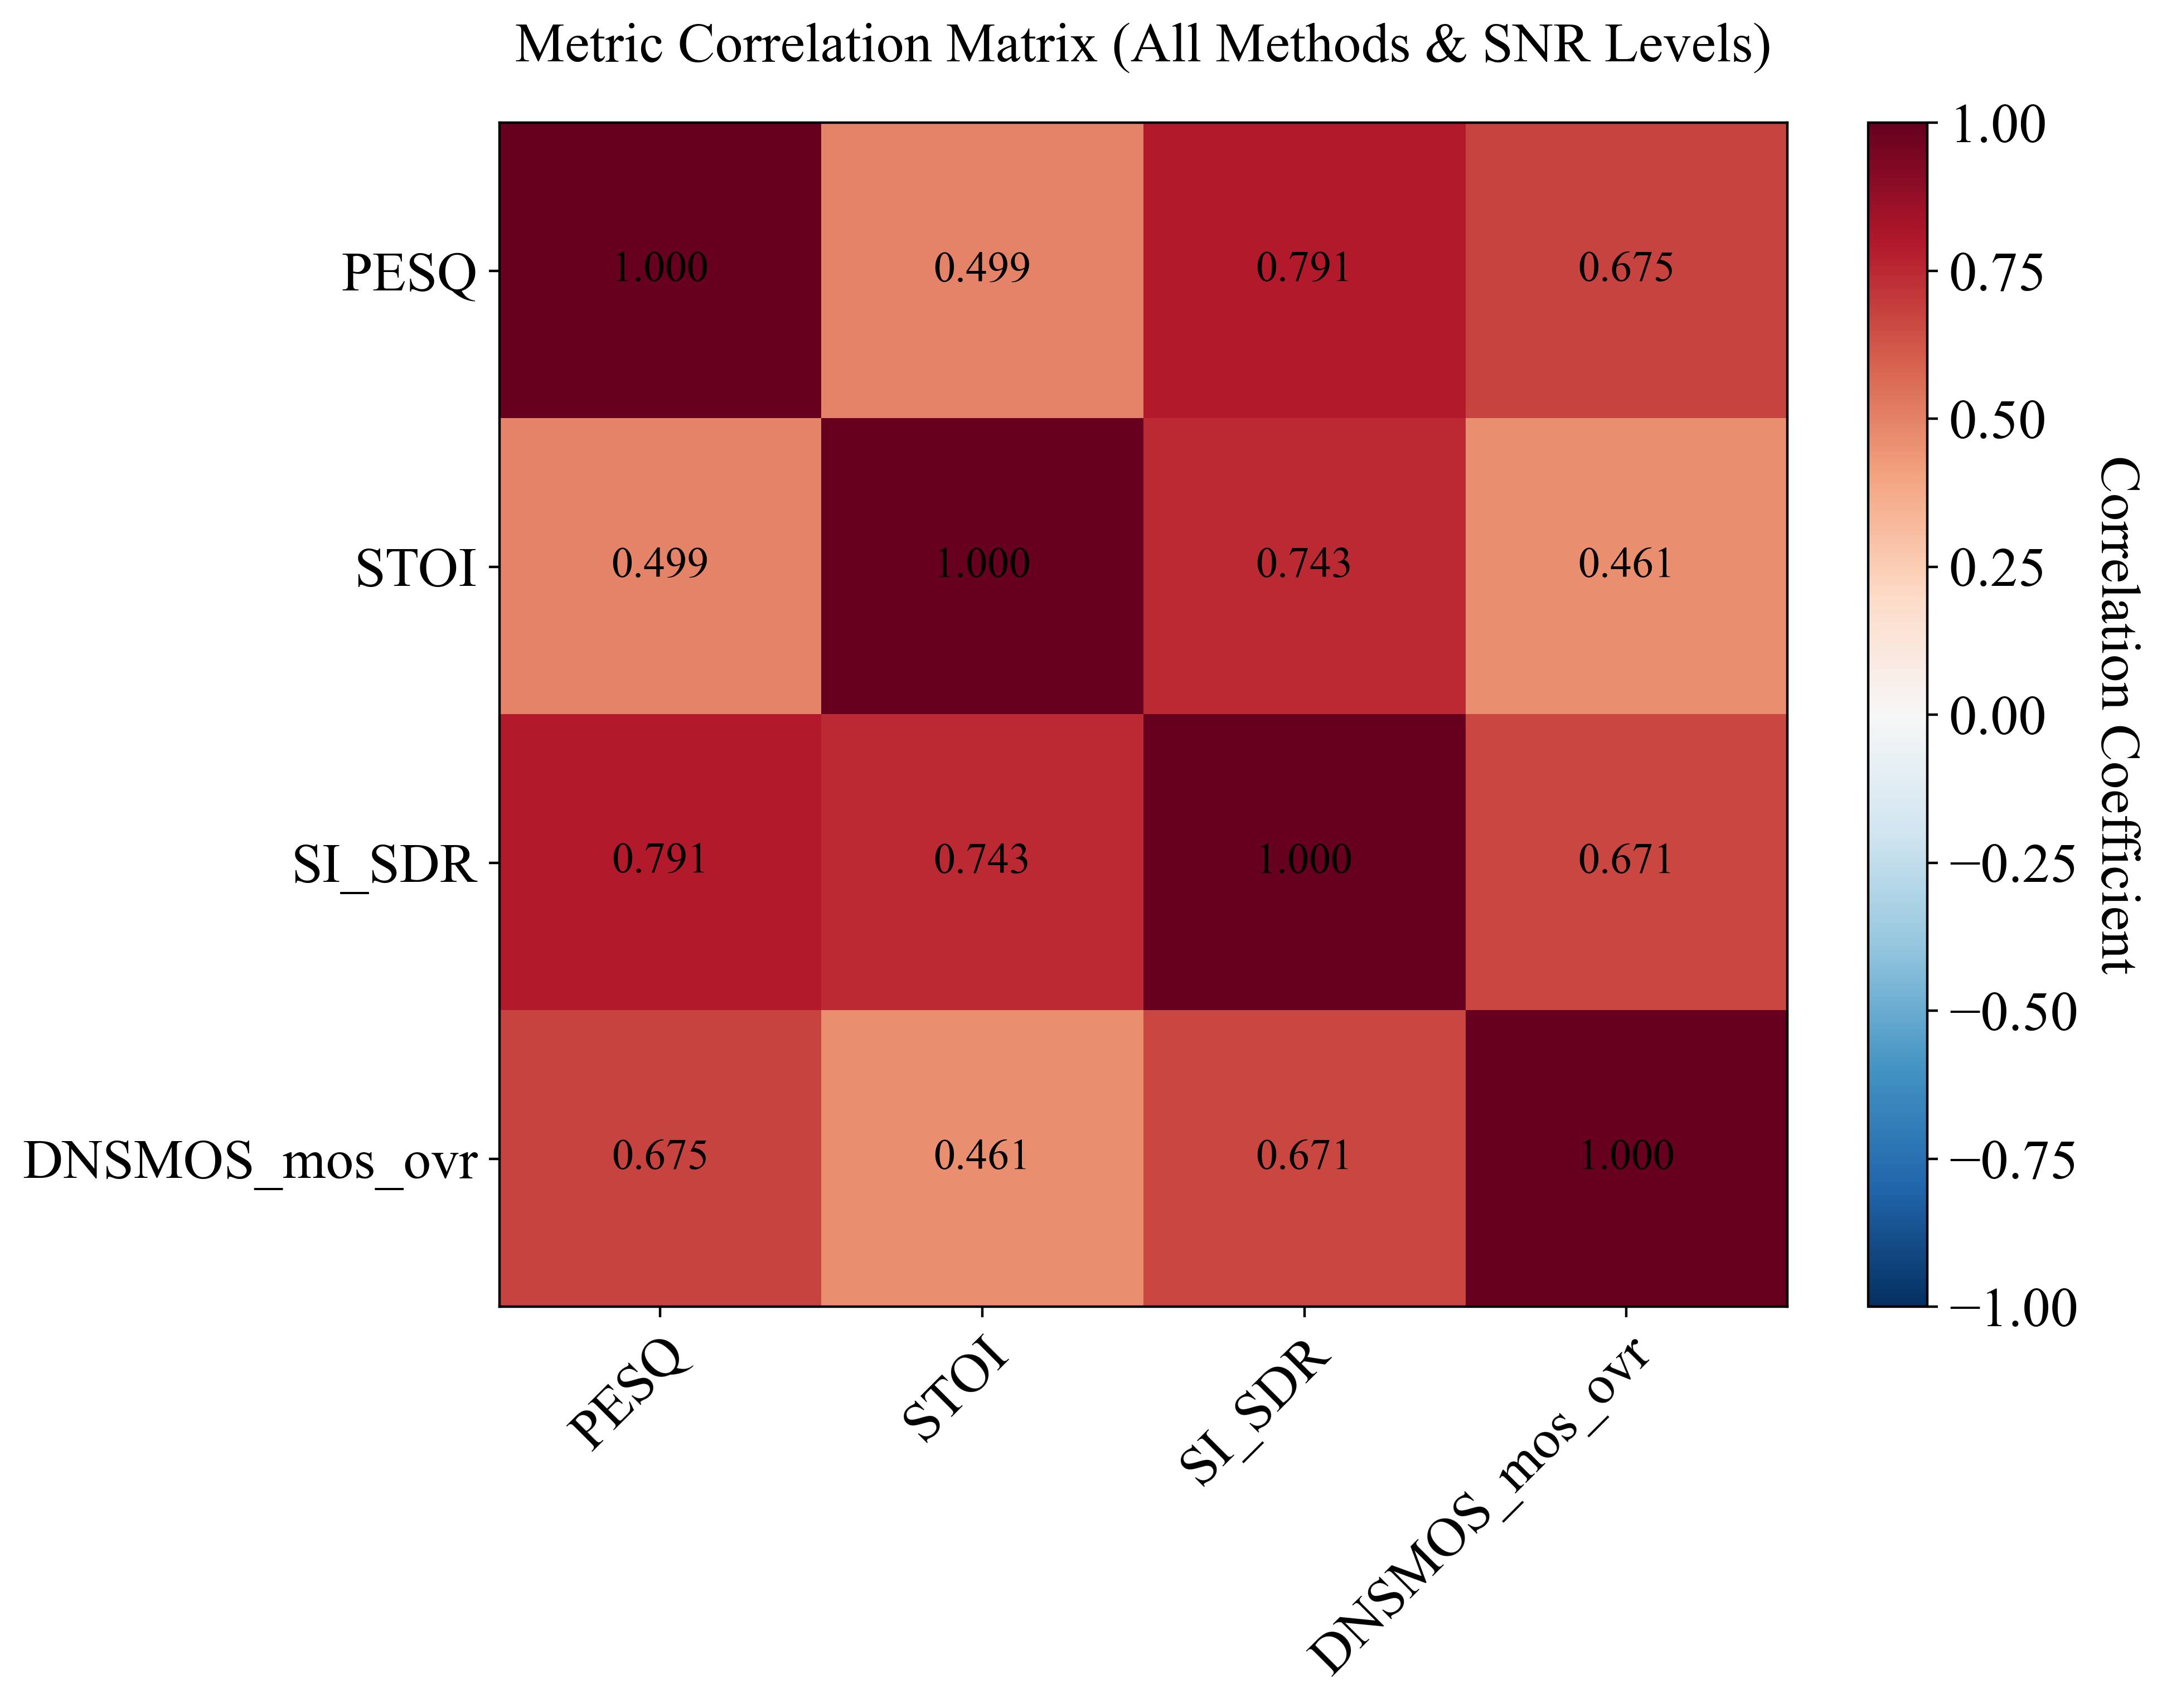


Correlation heatmap saved to: reports/figures/EXP3_metric_correlations.png


In [73]:
# Visualize correlation matrix as heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
im = ax.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

# Set ticks and labels
ax.set_xticks(np.arange(len(metrics)))
ax.set_yticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics)
ax.set_yticklabels(metrics)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

# Annotate with correlation values
for i in range(len(metrics)):
    for j in range(len(metrics)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=14)

ax.set_title('Metric Correlation Matrix (All Methods & SNR Levels)', fontsize=18, pad=20)
plt.tight_layout()
plt.savefig(repo_root / 'reports' / 'figures' / 'EXP3_metric_correlations.png', 
            dpi=400, bbox_inches='tight')
plt.show()

print("\nCorrelation heatmap saved to: reports/figures/EXP3_metric_correlations.png")


## 9. SNR-Specific Performance Analysis

Analyze how each method performs at different SNR levels and identify SNR-dependent patterns.

In [74]:
# Analyze improvements at each SNR level
print("=" * 100)
print(" " * 30 + "SNR-SPECIFIC ANALYSIS")
print("=" * 100)

for snr in snr_levels:
    print(f"\n{'=' * 100}")
    print(f"SNR = {snr} dB")
    print(f"{'=' * 100}")
    
    baseline = parse_baseline_csv(snr)
    wf = parse_wf_exp1p1d_csv(snr)
    td = parse_td_alone_csv(snr)
    wftd = parse_wftd_csv(snr)
    
    for metric in metrics:
        baseline_val = baseline[metric].mean()
        wf_val = wf[metric].mean()
        td_val = td[metric].mean()
        wftd_val = wftd[metric].mean()
        
        # Calculate improvements
        wf_improve = ((wf_val - baseline_val) / abs(baseline_val)) * 100
        td_improve = ((td_val - baseline_val) / abs(baseline_val)) * 100
        wftd_improve = ((wftd_val - baseline_val) / abs(baseline_val)) * 100
        
        # Find best method
        scores = {'BASELINE': baseline_val, 'WF': wf_val, 'TD': td_val, 'WFTD': wftd_val}
        best_method = max(scores.items(), key=lambda x: x[1])
        
        print(f"\n{metric}:")
        print(f"  BASELINE: {baseline_val:.4f}")
        print(f"  WF:       {wf_val:.4f}  (improvement: {wf_improve:+.2f}%)")
        print(f"  TD:       {td_val:.4f}  (improvement: {td_improve:+.2f}%)")
        print(f"  WFTD:     {wftd_val:.4f}  (improvement: {wftd_improve:+.2f}%)")
        print(f"  Best:     {best_method[0]} ({best_method[1]:.4f})")


                              SNR-SPECIFIC ANALYSIS

SNR = -5 dB

PESQ:
  BASELINE: 1.0658
  WF:       1.1022  (improvement: +3.42%)
  TD:       1.0682  (improvement: +0.23%)
  WFTD:     1.1008  (improvement: +3.29%)
  Best:     WF (1.1022)

STOI:
  BASELINE: 0.5866
  WF:       0.5801  (improvement: -1.10%)
  TD:       0.5857  (improvement: -0.14%)
  WFTD:     0.5787  (improvement: -1.35%)
  Best:     BASELINE (0.5866)

SI_SDR:
  BASELINE: -4.9899
  WF:       -0.2091  (improvement: +95.81%)
  TD:       -5.0600  (improvement: -1.40%)
  WFTD:     -0.3342  (improvement: +93.30%)
  Best:     WF (-0.2091)

DNSMOS_mos_ovr:
  BASELINE: 1.9706
  WF:       2.0815  (improvement: +5.63%)
  TD:       1.9722  (improvement: +0.08%)
  WFTD:     2.0830  (improvement: +5.71%)
  Best:     WFTD (2.0830)

SNR = 0 dB

PESQ:
  BASELINE: 1.0937
  WF:       1.1958  (improvement: +9.33%)
  TD:       1.0932  (improvement: -0.04%)
  WFTD:     1.1937  (improvement: +9.14%)
  Best:     WF (1.1958)

STOI:
  BASELIN

In [75]:
# Summary: Best method per metric per SNR level
print("\n" + "=" * 100)
print(" " * 25 + "BEST METHOD PER METRIC AT EACH SNR LEVEL")
print("=" * 100)

for metric in metrics:
    print(f"\n{metric}:")
    for snr in snr_levels:
        baseline = parse_baseline_csv(snr)
        wf = parse_wf_exp1p1d_csv(snr)
        td = parse_td_alone_csv(snr)
        wftd = parse_wftd_csv(snr)
        
        baseline_val = baseline[metric].mean()
        wf_val = wf[metric].mean()
        td_val = td[metric].mean()
        wftd_val = wftd[metric].mean()
        
        scores = {'BASELINE': baseline_val, 'WF': wf_val, 'TD': td_val, 'WFTD': wftd_val}
        best_method = max(scores.items(), key=lambda x: x[1])
        
        print(f"  SNR {snr:3d} dB: {best_method[0]:12s} ({best_method[1]:.4f})")

print("\n" + "=" * 100)



                         BEST METHOD PER METRIC AT EACH SNR LEVEL

PESQ:
  SNR  -5 dB: WF           (1.1022)
  SNR   0 dB: WF           (1.1958)
  SNR   5 dB: WF           (1.3865)
  SNR  10 dB: WF           (1.6921)
  SNR  15 dB: WF           (2.1097)

STOI:
  SNR  -5 dB: BASELINE     (0.5866)
  SNR   0 dB: WF           (0.6561)
  SNR   5 dB: WF           (0.7191)
  SNR  10 dB: WF           (0.7817)
  SNR  -5 dB: WF           (1.1022)
  SNR   0 dB: WF           (1.1958)
  SNR   5 dB: WF           (1.3865)
  SNR  10 dB: WF           (1.6921)
  SNR  15 dB: WF           (2.1097)

STOI:
  SNR  -5 dB: BASELINE     (0.5866)
  SNR   0 dB: WF           (0.6561)
  SNR   5 dB: WF           (0.7191)
  SNR  10 dB: WF           (0.7817)
  SNR  15 dB: WF           (0.8213)

SI_SDR:
  SNR  -5 dB: WF           (-0.2091)
  SNR   0 dB: WF           (4.4486)
  SNR   5 dB: WF           (8.7861)
  SNR  10 dB: WF           (12.8476)
  SNR  15 dB: WF           (16.2142)

DNSMOS_mos_ovr:
  SNR  -5 dB: WFTD 

## 10. Export Results

Export all analysis results to CSV files for further processing and reporting.

In [76]:
# Create output directory
output_dir = repo_root / 'reports' / 'EXP3_ANALYSIS'
output_dir.mkdir(parents=True, exist_ok=True)

# Export comparison DataFrame
comparison_export = comparison_df.pivot(index='SNR', columns='Metric', values=['BASELINE', 'WF', 'TD', 'WFTD'])
comparison_export.to_csv(output_dir / 'comparison_all_methods.csv')
print(f"✓ Exported: {output_dir / 'comparison_all_methods.csv'}")

# Export improvement DataFrame
improvement_export = improvement_df.pivot(index='SNR', columns='Metric', 
                                          values=['WF_Improvement_%', 'TD_Improvement_%', 'WFTD_Improvement_%'])
improvement_export.to_csv(output_dir / 'improvements_over_baseline.csv')
print(f"✓ Exported: {output_dir / 'improvements_over_baseline.csv'}")

# Export WFTD comparison DataFrame
wftd_export = wftd_comparison_df.pivot(index='SNR', columns='Metric', 
                                       values=['WFTD_vs_WF_%', 'WFTD_vs_TD_%'])
wftd_export.to_csv(output_dir / 'wftd_vs_individual.csv')
print(f"✓ Exported: {output_dir / 'wftd_vs_individual.csv'}")

# Export noise type comparison
noise_df.to_csv(output_dir / f'noise_type_comparison_{snr_test}dB.csv', index=False)
print(f"✓ Exported: {output_dir / f'noise_type_comparison_{snr_test}dB.csv'}")

# Export correlation matrix
correlation_matrix.to_csv(output_dir / 'metric_correlations.csv')
print(f"✓ Exported: {output_dir / 'metric_correlations.csv'}")

print(f"\n{'=' * 80}")
print(f"All results exported to: {output_dir}")
print(f"{'=' * 80}")


✓ Exported: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\reports\EXP3_ANALYSIS\comparison_all_methods.csv
✓ Exported: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\reports\EXP3_ANALYSIS\improvements_over_baseline.csv
✓ Exported: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\reports\EXP3_ANALYSIS\wftd_vs_individual.csv
✓ Exported: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\reports\EXP3_ANALYSIS\noise_type_comparison_5dB.csv
✓ Exported: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\reports\EXP3_ANALYSIS\metric_correlations.csv

All results exported to: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\reports\EXP3_ANALYSIS


In [77]:
# Create a summary report
summary_lines = []
summary_lines.append("=" * 100)
summary_lines.append(" " * 30 + "EXPERIMENT 3 - SUMMARY REPORT")
summary_lines.append("=" * 100)
summary_lines.append("")
summary_lines.append("ANALYSIS COMPLETED")
summary_lines.append("")
summary_lines.append("Methods Compared:")
summary_lines.append("  1. BASELINE - Noisy speech (no enhancement)")
summary_lines.append("  2. WF - Wiener Filter alone (25ms frames)")
summary_lines.append("  3. TD - TinyDenoiser GRU-based enhancement")
summary_lines.append("  4. WFTD - Wiener Filter + TinyDenoiser hybrid")
summary_lines.append("")
summary_lines.append(f"SNR Levels Tested: {snr_levels}")
summary_lines.append(f"Noise Types: {len(noise_types)} types")
summary_lines.append(f"Metrics Evaluated: {', '.join(metrics)}")
summary_lines.append("")
summary_lines.append("Output Files Generated:")
summary_lines.append("  Figures:")
summary_lines.append("    - EXP3_performance_comparison.png")
summary_lines.append("    - EXP3_percentage_improvements.png")
summary_lines.append("    - EXP3_wftd_vs_individual.png")
summary_lines.append(f"    - EXP3_noise_type_comparison_{snr_test}dB.png")
summary_lines.append("    - EXP3_metric_correlations.png")
summary_lines.append("")
summary_lines.append("  CSV Files:")
summary_lines.append("    - comparison_all_methods.csv")
summary_lines.append("    - improvements_over_baseline.csv")
summary_lines.append("    - wftd_vs_individual.csv")
summary_lines.append(f"    - noise_type_comparison_{snr_test}dB.csv")
summary_lines.append("    - metric_correlations.csv")
summary_lines.append("")
summary_lines.append("=" * 100)
summary_lines.append("OVERALL BEST METHODS (Average Across All SNR Levels)")
summary_lines.append("=" * 100)

for metric in metrics:
    metric_data = comparison_df[comparison_df['Metric'] == metric]
    avg_baseline = metric_data['BASELINE'].mean()
    avg_wf = metric_data['WF'].mean()
    avg_td = metric_data['TD'].mean()
    avg_wftd = metric_data['WFTD'].mean()
    
    scores = {'BASELINE': avg_baseline, 'WF': avg_wf, 'TD': avg_td, 'WFTD': avg_wftd}
    sorted_methods = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    summary_lines.append(f"\n{metric}:")
    summary_lines.append(f"  1st: {sorted_methods[0][0]:12s} ({sorted_methods[0][1]:.4f})")
    summary_lines.append(f"  2nd: {sorted_methods[1][0]:12s} ({sorted_methods[1][1]:.4f})")
    summary_lines.append(f"  3rd: {sorted_methods[2][0]:12s} ({sorted_methods[2][1]:.4f})")
    summary_lines.append(f"  4th: {sorted_methods[3][0]:12s} ({sorted_methods[3][1]:.4f})")

summary_lines.append("\n" + "=" * 100)

# Print and save summary
summary_text = "\n".join(summary_lines)
print(summary_text)

# Save summary to file
with open(output_dir / 'SUMMARY_REPORT.txt', 'w') as f:
    f.write(summary_text)

print(f"\n✓ Summary report saved to: {output_dir / 'SUMMARY_REPORT.txt'}")


                              EXPERIMENT 3 - SUMMARY REPORT

ANALYSIS COMPLETED

Methods Compared:
  1. BASELINE - Noisy speech (no enhancement)
  2. WF - Wiener Filter alone (25ms frames)
  3. TD - TinyDenoiser GRU-based enhancement
  4. WFTD - Wiener Filter + TinyDenoiser hybrid

SNR Levels Tested: [-5, 0, 5, 10, 15]
Noise Types: 20 types
Metrics Evaluated: PESQ, STOI, SI_SDR, DNSMOS_mos_ovr

Output Files Generated:
  Figures:
    - EXP3_performance_comparison.png
    - EXP3_percentage_improvements.png
    - EXP3_wftd_vs_individual.png
    - EXP3_noise_type_comparison_5dB.png
    - EXP3_metric_correlations.png

  CSV Files:
    - comparison_all_methods.csv
    - improvements_over_baseline.csv
    - wftd_vs_individual.csv
    - noise_type_comparison_5dB.csv
    - metric_correlations.csv

OVERALL BEST METHODS (Average Across All SNR Levels)

PESQ:
  1st: WF           (1.4973)
  2nd: WFTD         (1.4891)
  3rd: BASELINE     (1.2648)
  4th: TD           (1.2615)

STOI:
  1st: WF        